In [1]:
video_path = 'GOPR1077_tr.mp4'
model_path = 'best.pt' # path to .pt file from YOLOv10 notebook

# dimensions of photos the model was trained on
IMAGE_WIDTH = 416
IMAGE_HEIGHT = 416

In [2]:
!pip install -q av pillow

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [3]:
from ultralytics import YOLOv10
from PIL import Image
import numpy as np
import supervision as sv
import cv2
import av, os
from PIL import Image
import time



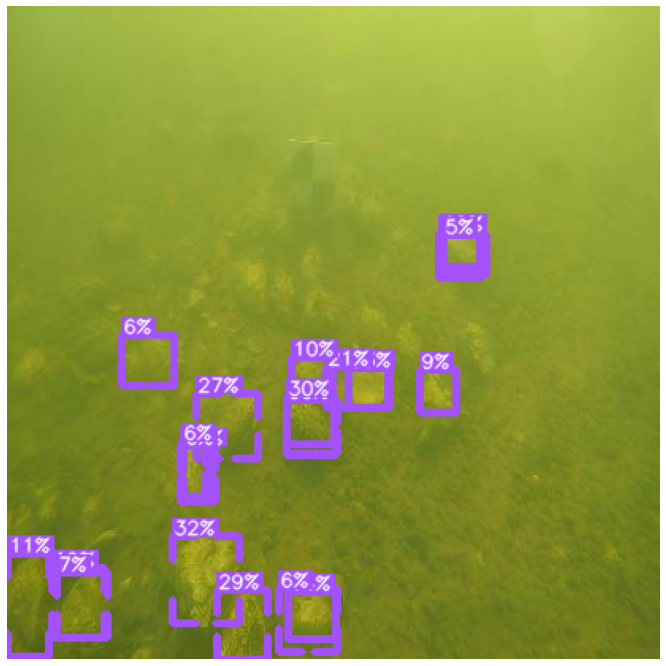

In [4]:
model = YOLOv10(model_path)
bba = sv.BoxCornerAnnotator()
la = sv.LabelAnnotator(text_scale = 0.4, text_padding = 1)

def run_pred(input_img, label_annotator = la, bounding_box_annotator = bba, verbose = False, conf = True, conf_level = 0.05):
    cont_img = np.ascontiguousarray(input_img, dtype=np.uint8)
    results = model(cont_img, conf=conf_level, verbose = verbose)[0]
    conf_array = np.array(results.boxes.conf.cpu())
    conf_ls_str  = [str(round(x * 100) ) + '%' for x in conf_array]
    
    detections = sv.Detections.from_ultralytics(results)
    annotated_image = bounding_box_annotator.annotate(
        scene=input_img, detections=detections)
#     print(detections)
    annotated_image = label_annotator.annotate(
        scene=annotated_image, detections=detections, labels = conf_ls_str)
    return(annotated_image)
# im_pil = Image.open("oyster_test.jpg")
# image = np.array(im_pil)
image_2 = np.array(Image.open('problem_photo_small.jpg'))
# print(im_pil.size)
ann_img = run_pred(image_2, conf_level = 0.05)
sv.plot_image(ann_img)

In [8]:
container = av.open(video_path)
stream_vid = container.streams.video[0]
fname = video_path.rsplit('/', 1)[-1]
per_index = fname.index('.')
out_path = f'{fname[:per_index]}_annotated.mp4'
start_time = time.time()
outp = av.open(out_path, 'w')
codec_name = stream_vid.codec_context.name
fps = stream_vid.codec_context.rate
output_stream = outp.add_stream(codec_name, str(fps))
output_stream.width = IMAGE_WIDTH
output_stream.height = IMAGE_HEIGHT
output_stream.pix_fmt = stream_vid.codec_context.pix_fmt

for index, frame in enumerate(container.decode(stream_vid)):
    pil_img = frame.to_image()
    np_img = np.array(pil_img)
    np_img_resize = cv2.resize(np_img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    np_rot = np_img_resize[:, :, ::-1]
    small_pil_img = Image.fromarray(np_rot)
    np_image_2 = np.array(small_pil_img)
    an_mg = run_pred(np_image_2)
    frame_out = av.VideoFrame.from_ndarray(an_mg, format='bgr24')
    pkt = output_stream.encode(frame_out)
    outp.mux(pkt)
container.close()
outp.close()

print(f'Annotated video has been saved as {out_path}')
end_time = time.time()

Annotated video has been saved as GOPR1077_tr_annotated.mp4


In [146]:
print(round(end_time - start_time))
# without any modification == 41.5
# with modification == 10

10
